# Matlab Project

In [1]:
import numpy as np
from numpy.linalg import lstsq
from numpy.random import normal
from matplotlib import pyplot as plt
%matplotlib inline

**<font color = blue>1. Dielectric constant of water and ice </font>**

In [2]:
def Dielectric_const(T,f):
    
    if T > 273.15:
        theta = 300 / T
        eta0 = 77.66 + 103.3 * (theta - 1.0)
        eta1 = 0.0671 * eta0
        eta2 = 3.52
        gamma1 = 20.2 - 146 * (theta - 1) + 316 * pow((theta - 1), 2)
        gamma2 = 39.8 * gamma1
        eta = eta0 - f * ((eta0 - eta1) / (f + 1j * gamma1) + (eta1 - eta2) / (f + gamma2 * 1j))
        eta = eta.conjugate()
    else:
        if hasattr(f, "__len__"):
            eta = np.ones(len(f)) * (3.15 - 0.01 * 1j)
        else:
            eta = 3.15 - 0.01 * 1j
    
    return eta

**<font color = blue>2. Surface reflectivity </font>**

In [3]:
def Reflection_indices(dconst, angle):
    '''
    angle -- degrees
    '''
    n2 = np.sqrt(dconst)
    theta = np.radians(angle)
    p = np.sqrt(pow(n2, 2) - pow(np.sin(theta), 2))
    V = (np.cos(theta) - p) / (np.cos(theta) + p)
    H = (p - pow(n2, 2) * np.cos(theta)) / (p + pow(n2, 2) * np.cos(theta))
    V = np.power(np.abs(V), 2)
    H = np.power(np.abs(H), 2)
    
    return V, H

**<font color = blue>3. An interfering cloud layer </font>**

In [4]:
def trans_bright(f, theta, temp, waterc):
    '''
    model of surface obsevations
    '''
    theta = np.radians(theta)
    gamma = waterc * f * 0.6
    tao = gamma / np.cos(theta)
    # TRANSMITIVITY
    t = np.exp(-tao)
    T = temp * t 
    return t, T

**<font color = blue>4. The forward model </font>**

In [5]:
def seaice_fm(f, polar, theta, ice_temp, ice_frac, waterc, temp):
    # WATER TEMPERTURE ASSUMPTION 
    water_temp = 277.15
    eta_water = Dielectric_const(water_temp, f)
    eta_ice = Dielectric_const(ice_temp, f)
    Vw, Hw = Reflection_indices(eta_water, theta)
    ref_water = np.column_stack((Vw, Hw))
    Vi, Hi = Reflection_indices(eta_ice, theta)
    ref_ice = np.column_stack((Vi, Hi))
    #  POLORIZATION 
    po_water = []
    po_ice = []
    for i, j in enumerate(polar):
        po_water.append(ref_water[i][j])
        po_ice.append(ref_ice[i][j])
    po_water = np.array(po_water)
    po_ice = np.array(po_ice)
    # ATMOSPHERIC EMISSION
    t, T = trans_bright(f, theta, temp, waterc)    
    # SURFACE EMISSION    
    Tb = ice_temp * (1 - po_ice) * ice_frac * t + water_temp * (1 - po_water) * (1 - ice_frac) * t + temp * (1 - t) * t * ((1 - ice_frac) * po_water + ice_frac * po_ice) 
    
    return Tb

**<font color = blue>5. Retrieval </font>**

In [6]:
def methodA(f, polar, theta, Tb):
    '''
    inverse process
    '''
    water_temp = 277.15
    eta_water = Dielectric_const(water_temp, f)
    eta_ice = Dielectric_const(260, f)
    Vw, Hw = Reflection_indices(eta_water, theta)
    ref_water = np.column_stack((Vw, Hw))
    Vi, Hi = Reflection_indices(eta_ice, theta)
    ref_ice = np.column_stack((Vi, Hi))
    #  POLORIZATION 
    po_water = []
    po_ice = []
    for i, j in enumerate(polar):
        po_water.append(ref_water[i][j])
        po_ice.append(ref_ice[i][j])
    po_water = np.array(po_water)
    po_ice = np.array(po_ice)
    K = np.column_stack((-(1 - po_water) * water_temp,  1 - po_ice))
    y = Tb - (1 - po_water) * water_temp
    
    return K, y

** CASE **

In [7]:
# FREQUECY SETTING
f = np.array([19.7, 19.7, 37, 37, 85.5, 85.5])
# POLARIZATION SETTING
polar = np.array([1, 0, 1, 0, 1, 0])
# INCIDENCE ANGLE
theta = 30.0
# ICE TEMPERTURE
ice_temp = 260.0
# ICE FRACTION
ice_frac = 0.5
# WATER CONTENT
waterc = 0.0
# CLOUD TEMPERTURE
temp = 290
# BRIGHTNESS TEMPERTURE 
Tb = seaice_fm(f, polar, theta, ice_temp, ice_frac, waterc, temp)
# METHOD A ADDING NOIZE
Tb1 = Tb + normal(0, 0.5, len(Tb))

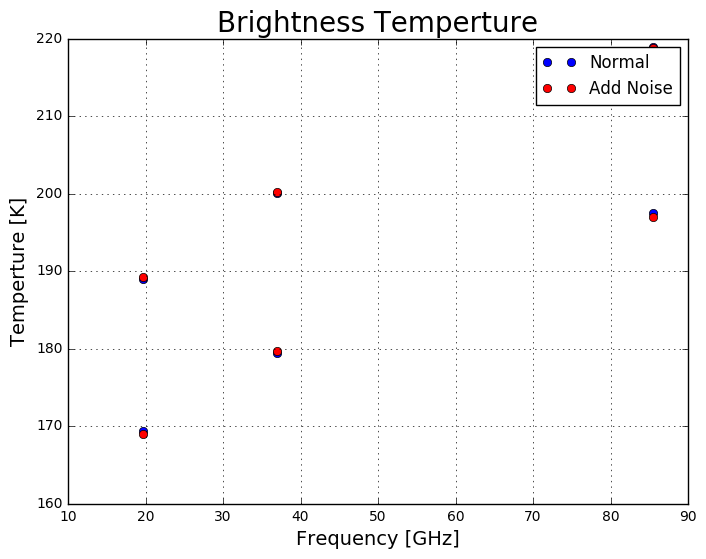

In [8]:
fig = plt.figure(figsize=(8, 6))
plt.title("Brightness Temperture", fontsize = 20)
plt.plot(f, Tb, "bo", label = "Normal")
plt.plot(f, Tb1, "ro", label = "Add Noise")
plt.xlabel("Frequency [GHz]", fontsize = 14)
plt.ylabel("Temperture [K]", fontsize = 14)
plt.grid()
plt.legend(loc = 1)
plt.show()

In [9]:
# GENERATE MATRIX EQUATION
K, y = methodA(f, polar, theta, Tb1)
# LEAST SQUARES FITS
Ans1 = lstsq(K, y)[0]

In [10]:
print "Estimate concentration = %f\nEstimate ice Temperture = %f\nReal concentration = %f\nReal ice temperture = %f" %(Ans1[0], Ans1[1]/ Ans1[0], ice_frac, ice_temp)

Estimate concentration = 0.501045
Estimate ice Temperture = 259.711973
Real concentration = 0.500000
Real ice temperture = 260.000000


In [ ]:
eta = 